# SCimilarity search for fibrosis associated macrophages across 22.7M cells
The goal of this tutorial is to familiarize users with SCimilarity's basic functionallities. The application is to FM$\phi$ and loosely parralels much of the FM$\phi$ analysis for Figure 5 from the [SCimilarity manuscript](https://www.biorxiv.org/content/10.1101/2023.07.18.549537v1.abstract).

- System requirements
   - At least 64GB of RAM
   - SCimilarity package installed
 - Note: these are large files. Ddownloading and processing can take a several minutes.

## 0. Required software and data
Things you need for this demo:

 0. SCimilarity package should already be installed

 1. Models

 2. Query data
    - We will use [Adams et al., 2020](https://www.science.org/doi/10.1126/sciadv.aba1983?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) healthy and IPF lung scRNA-seq data
    - GEO Source: [GSE136831](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE136831) (~2.5GB)


### Download tutorial data and models
Download the tutorial data, a subsample of GSE136831, from [Zenodo](https://zenodo.org):

- [Download tutorial data](https://zenodo.org)
- [Download annotation model](https://zenodo.org)
- [Download cell search model](https://zenodo.org)

In [ ]:
# Environment settings
import scanpy as sc
sc.set_figure_params(dpi=100)

import warnings
warnings.filterwarnings('ignore')

## 1. Prepare for SCimilarity: Import and normalize data

In [3]:
from scimilarity.utils import lognorm_counts
from scimilarity import CellAnnotation, align_dataset

### Import SCimilarity - Cell annotation object

In [4]:
# Instantiate the CellAnnotation object.
# Replace model_path with your local file path.
model_path = '/models/model_2023_01_rep0'
ca = CellAnnotation(model_path=model_path)

### Load scRNA-seq data

In [ ]:
# Load the tutorial data.
# Replace data_path with your local file path.
data_path = '/data/subsample_for_demo.h5ad'
adams = sc.read(data_path)

### SCimilarity pre-processing
SCimilarity requires new data to be processed in a specific way that matches how the model was trained. 

#### Match feature space with SCimilarity models 
SCimilarity's gene expression ordering is fixed. New data should be re-orderd to match that. Genes that are not present in the new data will be zero filled to comply to the expected structure. Genes that are not present in SCimilarity's gene ordering will be filtered out. 

Note: SCimilarity was trained with high data dropout to increase robustness to differences in gene lists. 

In [5]:
adams = align_dataset(adams, ca.gene_order)

#### Normalize data consistent with SCimilarity
It is important to match Scimilarity's normalization so that the data matches the lognorm tp10k procedure used during model training.

In [6]:
adams = lognorm_counts(adams)

With these simple steps, the data is now ready for SCimilarity. We are able to filter cells later (even after embedding) because SCimilarity handles each cell indepdendently and can skip highly variable gene selection altogether.

## 2. Compute embeddings
Using the already trained models, SCimilarity can embed your new dataset. 

In [7]:
adams.obsm['X_scimilarity'] = ca.get_embeddings(adams.X)

### Compute visualization of embeddings
#### Use UMAP to visualize SCimilarity embeddings

In [8]:
sc.pp.neighbors(adams, use_rep='X_scimilarity')
sc.tl.umap(adams)

### Visualize author annotations on the SCimilarity embedding
Given that author annotations are derived from a different analysis, seeing author annotations roughly cluster in SCimilarity embedding space gives us confidence in our representation. 

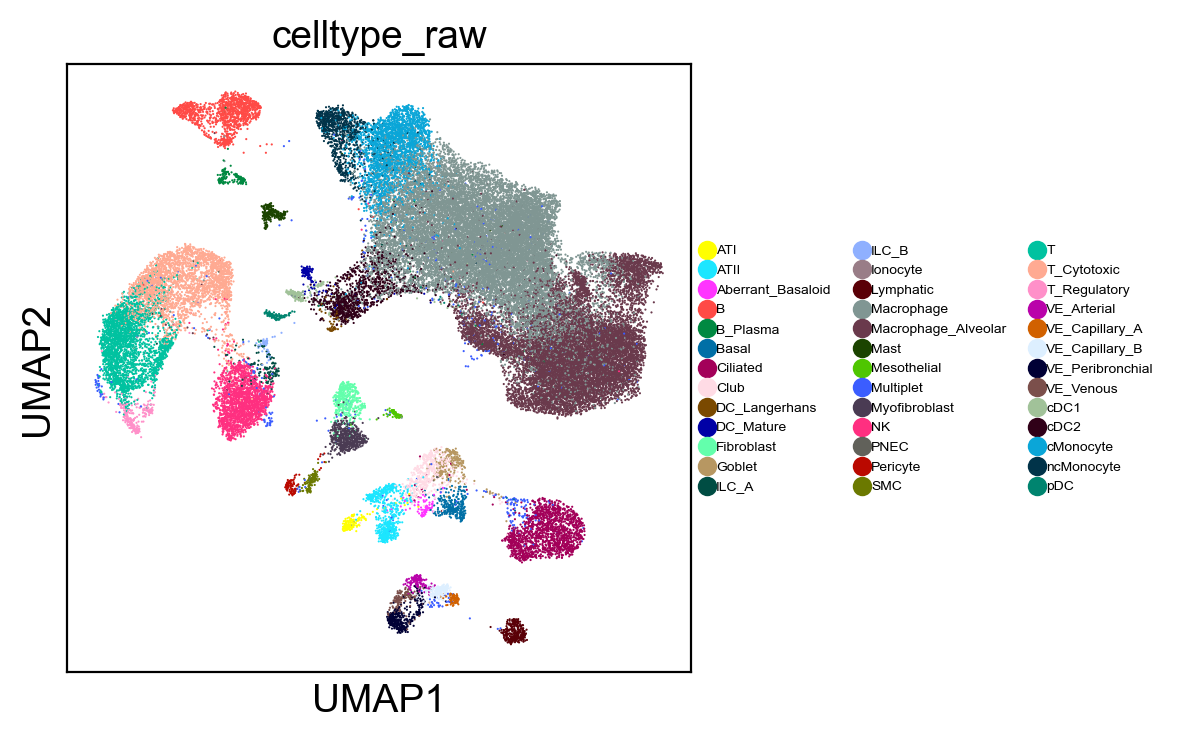

In [9]:
sc.pl.umap(adams, color='celltype_raw', legend_fontsize=5)

Adams et al dataset was not included in the training set, meaning that this is the first time the model has seen this data, yet it is still able to represent the cell types present. 

## 3. Cell type classification

Two methods within the CellAnnotation class:
 1. `annotate_dataset` - automatically computes embeddings
 2. `get_predictions` - more detailed control of annotation

*Description of inputs*
 - X_scimilarity: embeddings from the model, which can be used to generate umaps in lieu of PCA and is in theory general across datasets    

*Description of outputs*
 - predictions: celltype label predictions.
 - nn_idxs: indicies of cells in the SCimilarity reference. 
 - nn_dists: the minimum distance within k=50 nearest neighbors.
 - nn_stats: a dataframe containing useful metrics such as: 
     - hits: the distribution of celltypes in k=50 nearest neighbors.

### Unconstrained annotation
Cells can be classified as any type that is in the SCimilarity reference 

In [10]:
predictions, nn_idxs, nn_dists, nn_stats = ca.get_predictions_kNN(adams.obsm['X_scimilarity'])
adams.obs['predictions_unconstrained'] = predictions.values

Get nearest neighbors finished in: 0.04693396886189779 min


100%|██████████| 50000/50000 [00:25<00:00, 1965.83it/s]


#### Since each cell is classified independently, there is higher classification noise, filtering out low count cells can reduce the noise in visualization



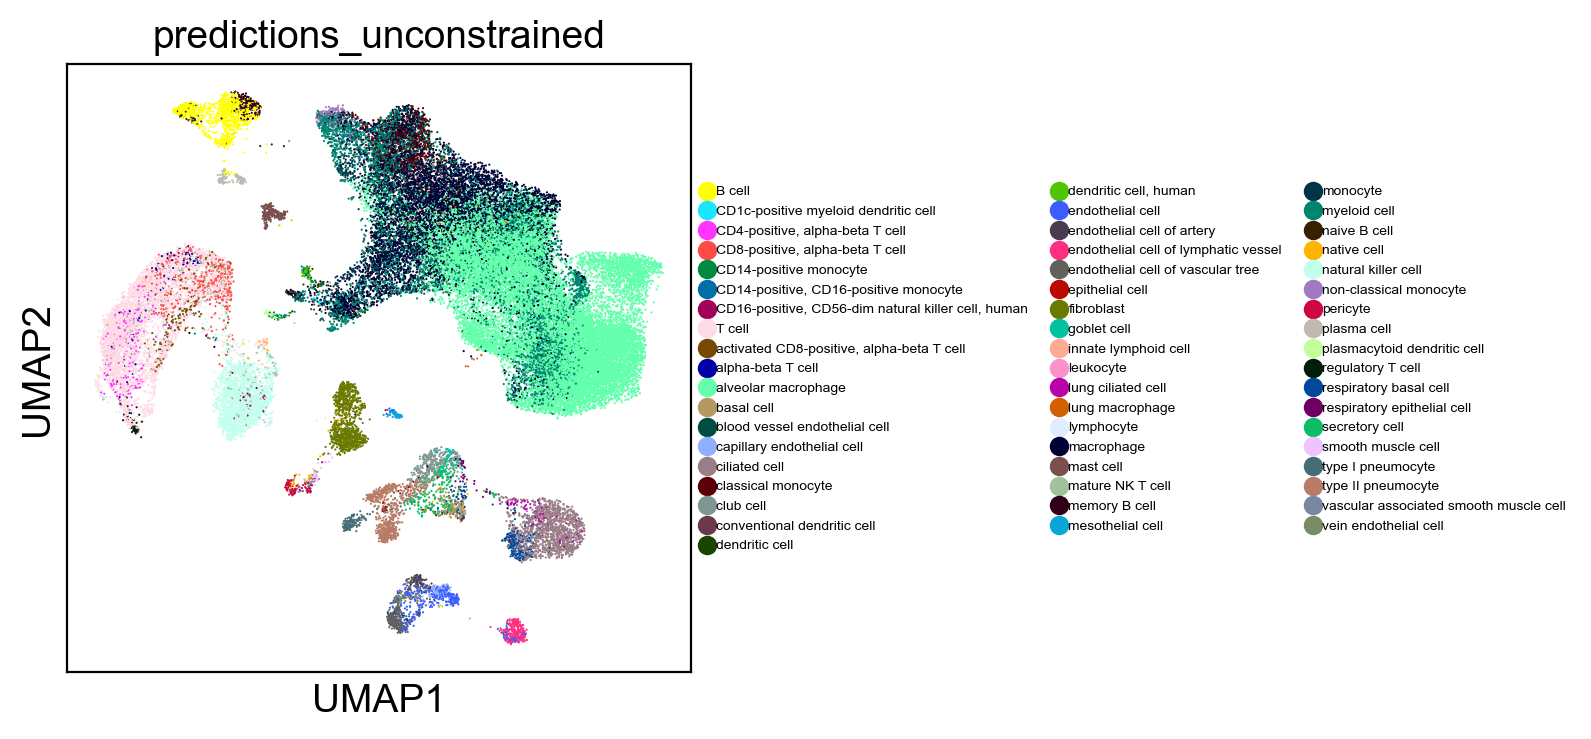

In [11]:
celltype_counts = adams.obs.predictions_unconstrained.value_counts()
well_represented_celltypes = celltype_counts[celltype_counts>20].index

sc.pl.umap(adams[adams.obs.predictions_unconstrained.isin(well_represented_celltypes)], 
           color='predictions_unconstrained', 
           legend_fontsize=5)

### Constrained classification
By classifying against the full reference, we can get redundant cell types, e.g. activated CD8-positive, alpha-beta T cell and CD8-positive, alpha-beta T cell.

Alternatively we can subset the reference to just the cell types we want to classify to. This can lead to less cell type annotation noise.

Note: subsetting can slow classification speeds due kNN optimization for full reference classification.

In [12]:
target_celltypes = ['alveolar macrophage', 'macrophage', 'natural killer cell', 'ciliated cell', 'mature NK T cell',
                    'B cell', 'fibroblast', 'classical monocyte', 'type II pneumocyte', 'endothelial cell of vascular tree',
                    'club cell', 'endothelial cell of lymphatic vessel', 'CD8-positive, alpha-beta T cell',
                    'respiratory basal cell', 'mast cell', 'type I pneumocyte', 'secretory cell', 'CD4-positive, alpha-beta T cell',
                    'lung macrophage', 'plasma cell', 'basal cell', 'non-classical monocyte', 'plasmacytoid dendritic cell',
                    'lung ciliated cell', 'vascular associated smooth muscle cell', 'conventional dendritic cell',
                    'goblet cell', 'smooth muscle cell', 'pericyte', 'regulatory T cell', 'myofibroblast cell',
                    'neuroendocrine cell', 'pulmonary ionocyte']

ca.safelist_celltypes(target_celltypes)

In [13]:
adams = ca.annotate_dataset(adams, skip_preprocessing=True) # we already pre-processed the data

Get nearest neighbors finished in: 0.09902852773666382 min


100%|██████████| 50000/50000 [00:26<00:00, 1857.43it/s]


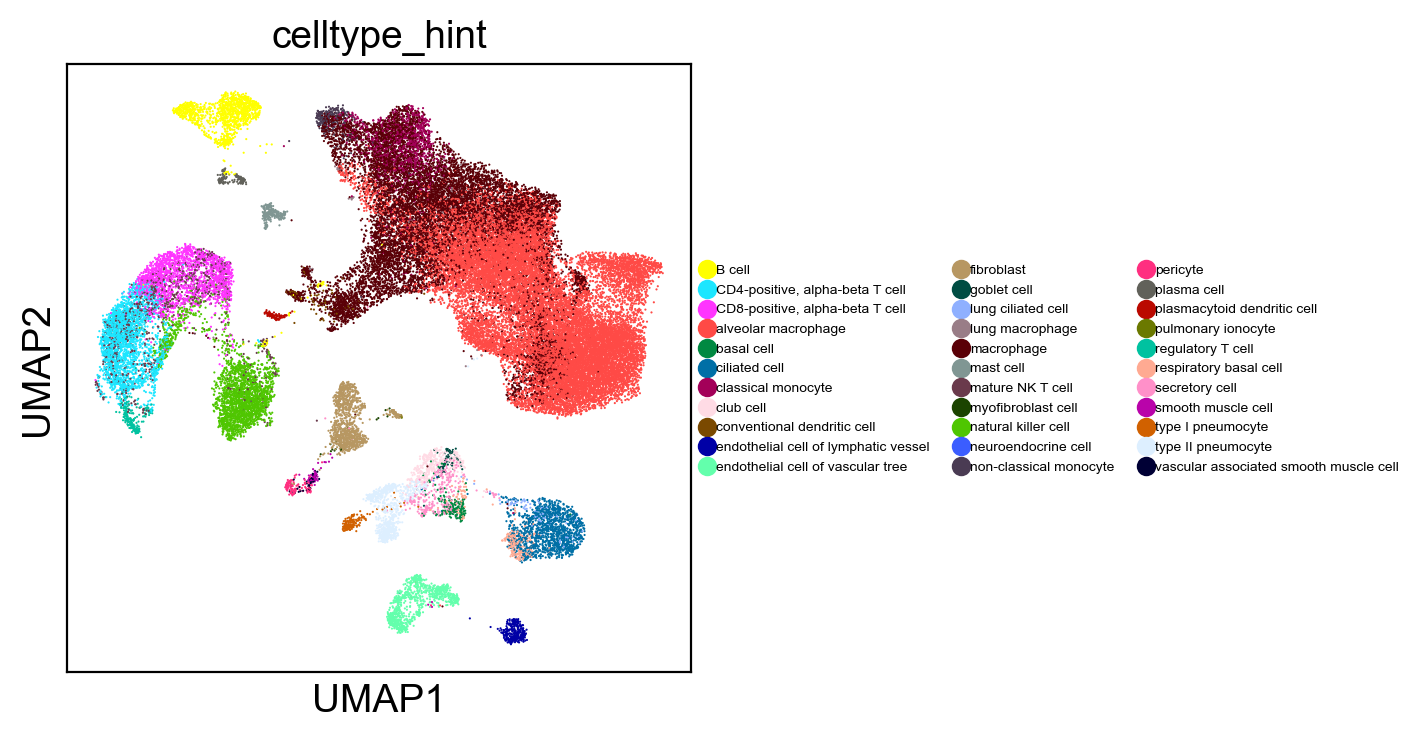

In [14]:
sc.pl.umap(adams, color='celltype_hint', legend_fontsize=5)

### Annotation QC
Cell annotation also computes QC metrics for our annotations. One of which, `min_dist`, represents the minimum distance between a cell in the query dataset and all cells in the training set. The greater `min_dist`, (i.e. the further away from what the model has seen before) the less confidence we have in the model's prediction. 

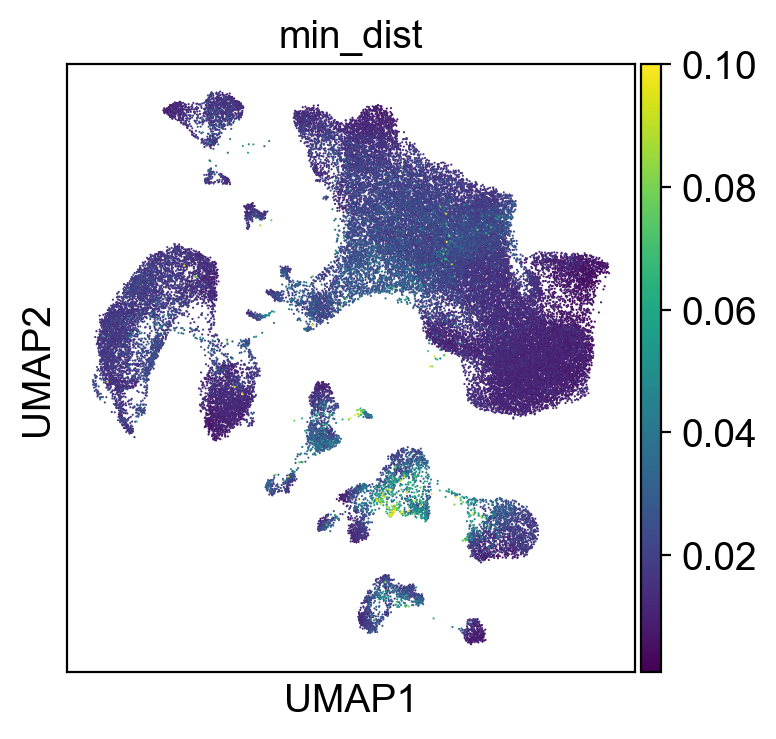

In [15]:
sc.pl.umap(adams, color='min_dist', vmax=.1)

## 4. Identify query cell state
As in the SCimilarity manuscript, we use a signature to identify the cells you want to query. There are many other ways to select a query cell state such as granular clustering and looking at expression patterns of a specific gene.

In [16]:
fm_basic_signature = ['SPP1', 'TREM2', 'GPNMB', 'MMP9', 'CHIT1', 'CHI3L1']
sc.tl.score_genes(adams, fm_basic_signature)

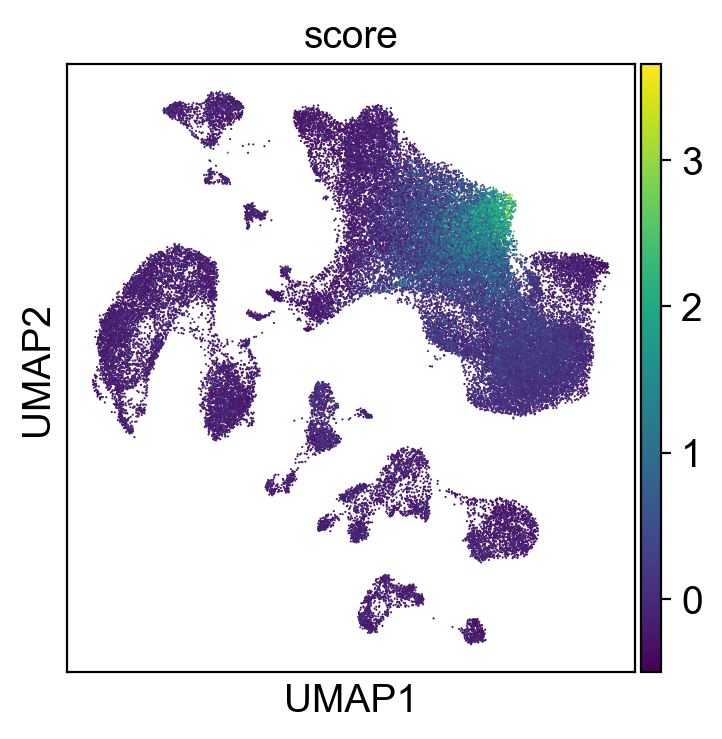

In [17]:
sc.pl.umap(adams, color='score')

### Determine query profile
We will query on the centroid of the top $n$ cells that score on our signature

#### Select the top scoring cells to define our query cell state
To identify similar cells, we input a query profile representing the cell state of interest. In this case, we will use the average expression profile of cells above the 99.9th percentile of our signature score. 

Note: An overly broad cell selection can limit query results.

In [18]:
sig_query_threshold = adams.obs.score.quantile(.999)
cells_used_in_query = adams.obs.score>=sig_query_threshold
adams.obs['used_in_query'] = cells_used_in_query

#### Compute centroid of top scoring cells and compute embedding

In [19]:
from scimilarity.utils import get_centroid

In [20]:
avg_cell = get_centroid(adams.layers['counts'][adams.obs['used_in_query']])
avg_embedding = ca.get_embeddings(avg_cell)

## 5. Cell Query
After defining a cell state you want to query, 
 - use top 50 scoring cells to represent query cell state

### Import SCimilarity cell search method

In [21]:
from scimilarity import CellQuery

cellsearch_path = '/models/model_2023_01_rep0_cellsearch_2023_01'
cq = CellQuery(model_path=model_path, 
               cellsearch_path=cellsearch_path)

### Perform cell search
 - Search for k=10000 most simliar cells across 22.7M cell reference and extract metadata for each cell
 - For sub-second searches, with less frills, use cq.get_nearest_neighbors
 - Note: many of the search results will be from the Adams dataset
 
 *Input for cq.search()* 
 - Model embedding which we calculate from cq.get_embedding() (or ca.get_embedding() as we did above)
 - k representing the number of neighbours we would like to find
 
 *Output of cq.search()*
 - nn_idxs: indices of neighbour cells in the SCimilarity reference
 - nn_dists: the distance between neighbour cells and the query 
 - metadata: a dataframe containing the metadata associated with each cell
 

In [22]:
%%time 
k = 10000
nn_idxs, nn_dists, results_metadata = cq.search(avg_embedding, k=k)

CPU times: user 6.65 s, sys: 1.1 s, total: 7.75 s
Wall time: 7.75 s


### Interpret results
Now that they query has returned the most similar cells, we can look at the cells to see which studies and conditions they are present in. 

In [23]:
def calculate_disease_proportions(metadata):
    study_proportions = metadata.disease.value_counts()
    return 100*study_proportions / study_proportions.sum()

def plot_proportions(df, title=None):
    ax = df.plot(kind='barh', 
            xlabel='percent of cells',
            title=title, 
            grid=False,
            figsize=(4,4))
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xticklabels([f'{int(tick)}%' for tick in ax.get_xticks()]);

##### Exclude self-referencing results
Naturally, queries searching for similar cells will highlight cells from the same study. To get a clearer view of the results, we often exclude those self-referencing hits.

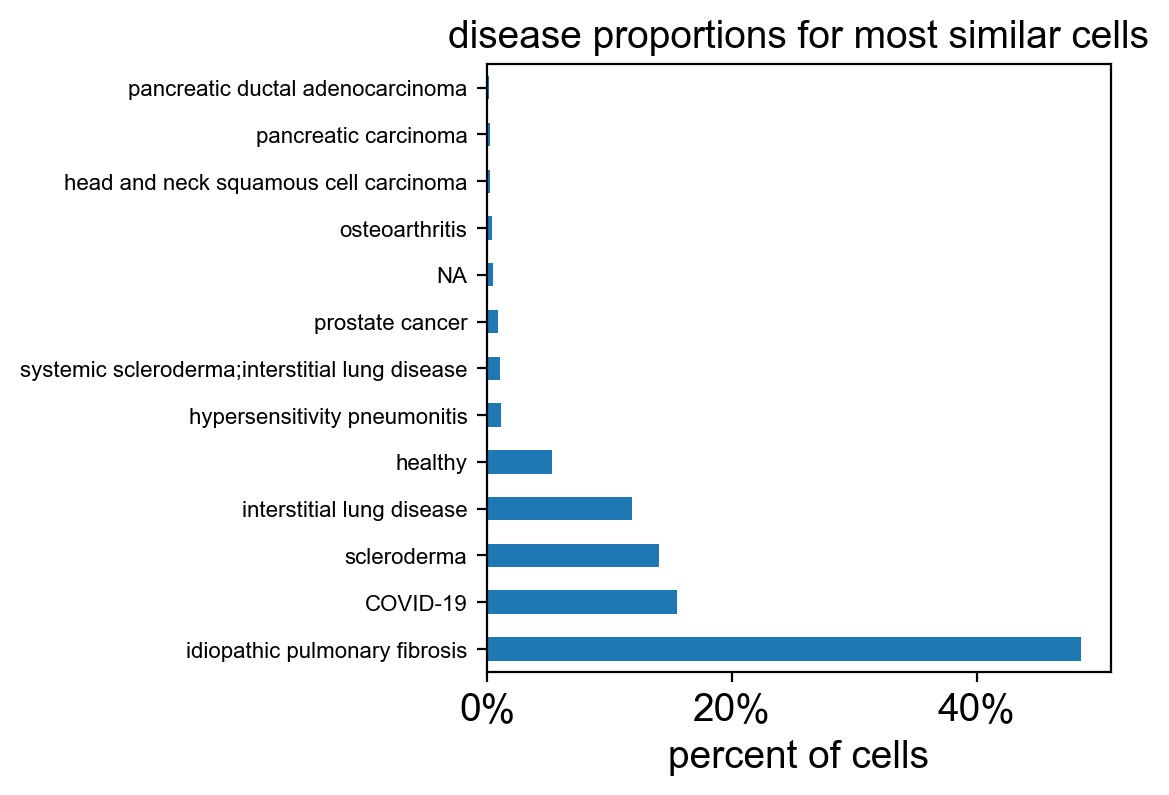

In [24]:
query_study = 'DS000011735'
filtered_result_metadata = results_metadata[results_metadata.study!=query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
plot_proportions(query_disease_frequencies, 
                 title='disease proportions for most similar cells')

This query shows higher proportion of IPF cells than healthy cells. However results can be skewed by the imbalanced abundances of diseases and tissues in the query reference. We can test for enrichment by counting the number of predicted macrophages (already precompted in `cq.cell_metadata`) across diseases for both our query hits and the full reference.

#### Get reference cell metadata
Sample metadata has been curated to be able to see tissue, disease, etc for each cell. In this metadata table each row corresponds to a cell that is matched by index across the full knn index and precomputed cell embeddings.

In [25]:
ref_metadata = cq.cell_metadata

#### Compare to background of macrophages across lung diseases
To see how enriched our results are for a disease of interested, we can visualize this imbalance. 
1. Subset the full reference metadata to cells that are from lung samples and predicted to be macrophages 
2. Tabulate the cell counts by disease state
3. Visualize the lung macrophage disease imbalance wihtin the reference collection

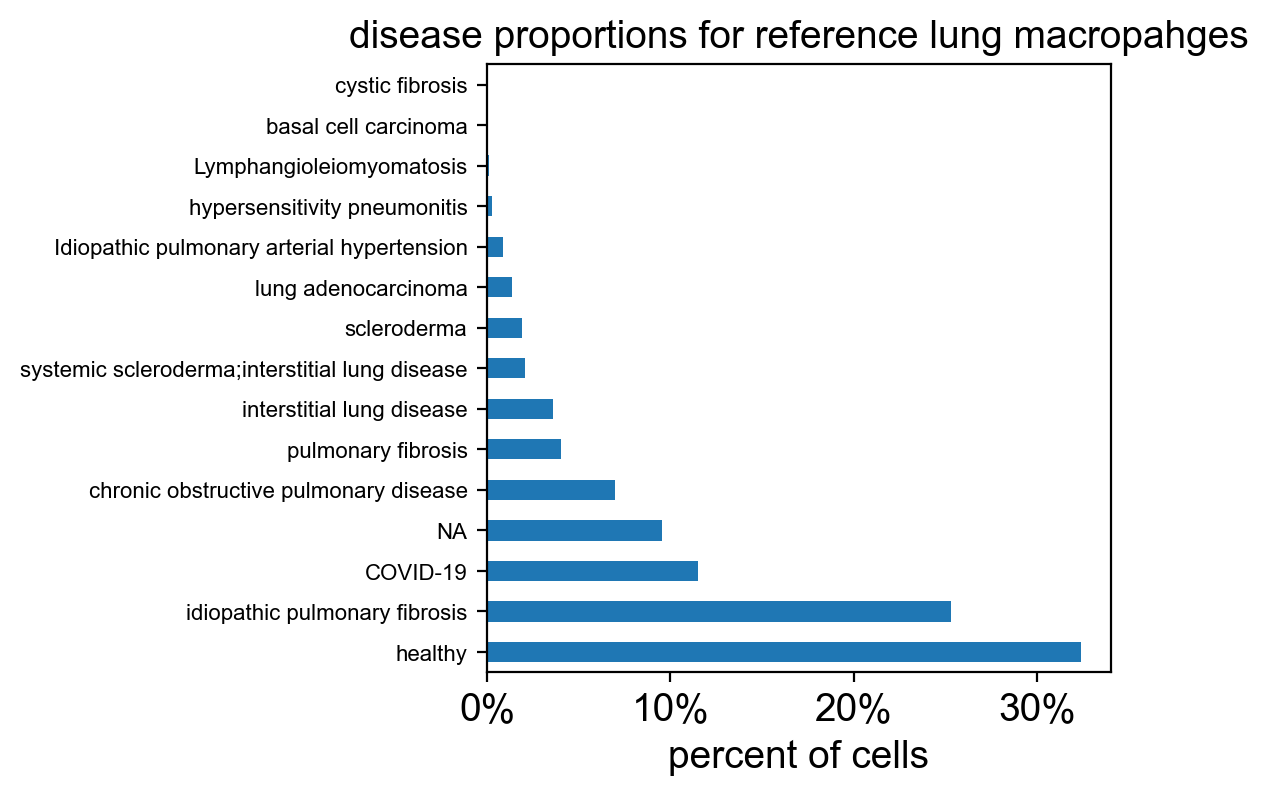

In [26]:
lung_mac_meta = ref_metadata[(ref_metadata.tissue == 'lung') & \
                             ref_metadata.prediction.isin(['macrophage', 'alveolar macrophage'])]
query_disease_frequencies = calculate_disease_proportions(lung_mac_meta)
plot_proportions(query_disease_frequencies[:15], title='disease proportions for reference lung macropahges')

Over 30% of the lung macrophages in the reference are from healthy tissues, while in our query they make up less than 10% of the cells most similar to our query. This confirms that these cells are in fact found in pulmonary fibrosis while they are more rare in healthy lung samples. 

## Conclusion: How to apply to your own datasets
This notebook outlines how to take a dataset, select a query population, perform the cell search across our precomputed indices for 22.7M cells and summarize the results. You can use this as a template to expore cell states in other datasets you are interested in. 


 - Keep in mind that the datasets that you analyze with SCimilarity should fit the following criteria:
   - Data generated from 10X Chromium machine (models are trained using this data only).
   - Human scRNA-seq data.
   - Normalized from counts with SCimilarity functions or using the same process. Different normalizations will have poor results.
   
Check out the next tutorial for more flexible uses of SCimilarity!